# Variational AutoEncoder (VAE)
Adapted from https://github.com/Jackson-Kang/Pytorch-VAE-tutorial

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>

[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/ZerojumpLine.github.io/blob/master/teaching/2025-08-08-Pattern%20Recognition/code_4_vae.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZiqaokPlc_e9KCRtOhYaPFTX4NKUzUmr#scrollTo=UGF0t5YhG-Fk)

# Install required packages

In [1]:
!pip install torch
!pip install matplotlib

In [2]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [3]:
# Model Hyperparameters

dataset_path = '~/datasets'

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [5]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [7]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [8]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [9]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [10]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


	Epoch 1 complete! 	Average Loss:  175.0465806128704
	Epoch 2 complete! 	Average Loss:  128.90606839850273
	Epoch 3 complete! 	Average Loss:  116.97019198664441
	Epoch 4 complete! 	Average Loss:  112.97430726014711
	Epoch 5 complete! 	Average Loss:  110.6636990198508
	Epoch 6 complete! 	Average Loss:  109.06746030167467
	Epoch 7 complete! 	Average Loss:  107.74997078464106
	Epoch 8 complete! 	Average Loss:  106.72171278302379
	Epoch 9 complete! 	Average Loss:  105.93948053070221
	Epoch 10 complete! 	Average Loss:  105.06694583746348
	Epoch 11 complete! 	Average Loss:  104.39186422357575
	Epoch 12 complete! 	Average Loss:  103.90174390585872
	Epoch 13 complete! 	Average Loss:  103.5466619496035
	Epoch 14 complete! 	Average Loss:  103.15721392750939
	Epoch 15 complete! 	Average Loss:  102.90074143755217
	Epoch 16 complete! 	Average Loss:  102.59622096397642
	Epoch 17 complete! 	Average Loss:  102.38915857483828
	Epoch 18 complete! 	Average Loss:  102.17129713259078
	Epoch 19 complete! 	A

### Step 5. Generate images from test dataset

In [11]:
import matplotlib.pyplot as plt

In [12]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|                                                                                                                                   | 0/100 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|                                                                                                                                   | 0/100 [00:01<?, ?it/s]


Let's visualize test samples alongside their reconstruction.

In [13]:
def show_image_grid_detailed(x, nrows=10, ncols=10):
    x = x.view(-1, 28, 28)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
    
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            if idx < len(x):
                axes[i, j].imshow(x[idx].cpu().numpy(), cmap='gray')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

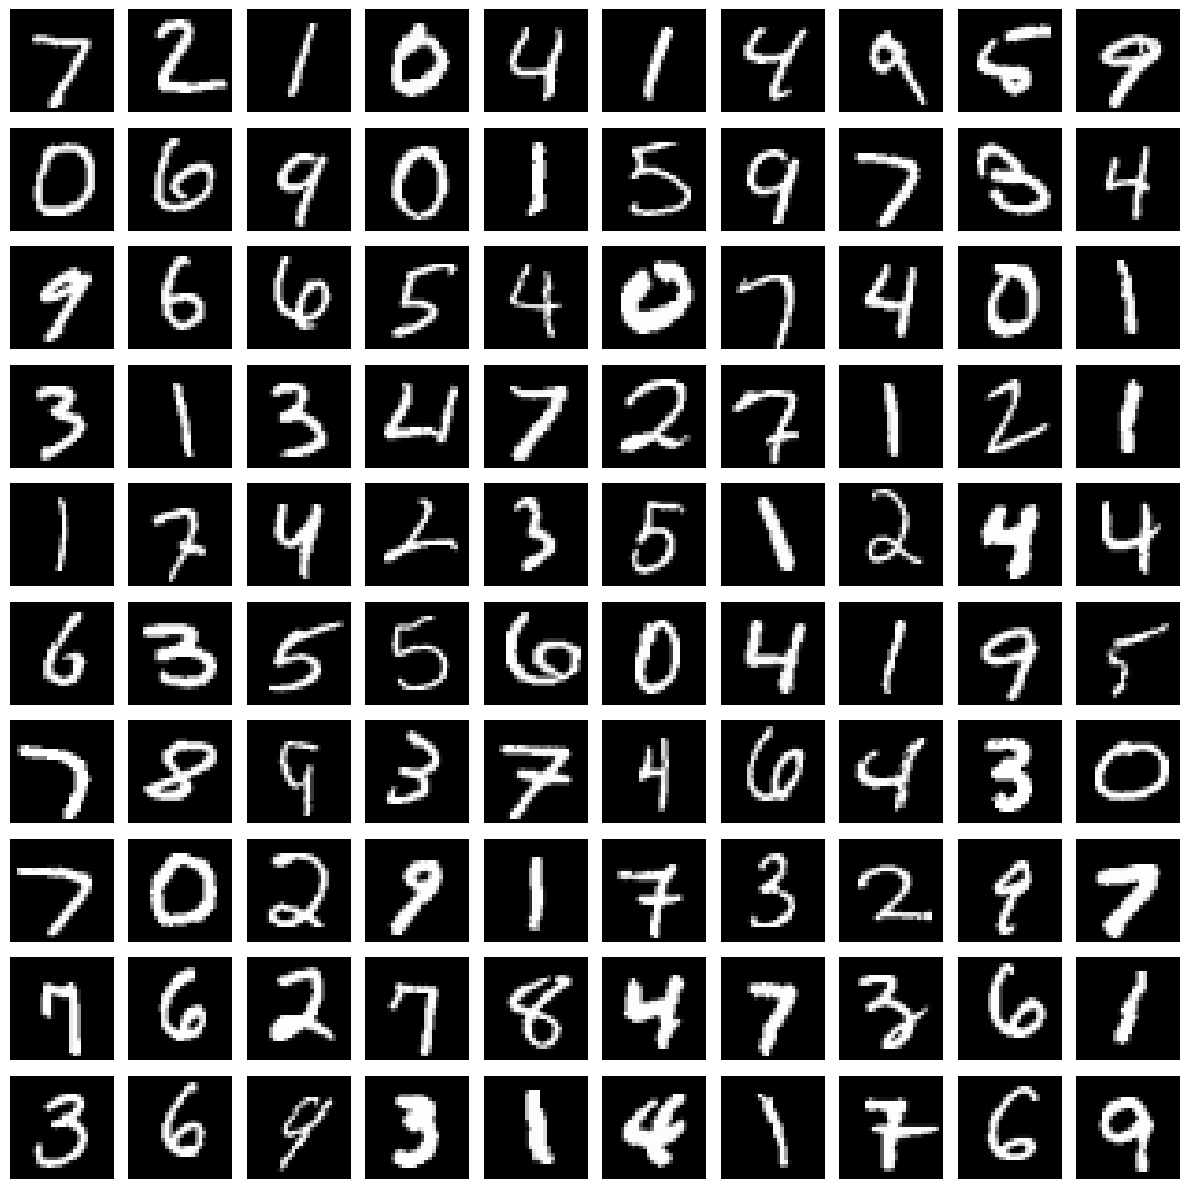

In [14]:
show_image_grid_detailed(x)

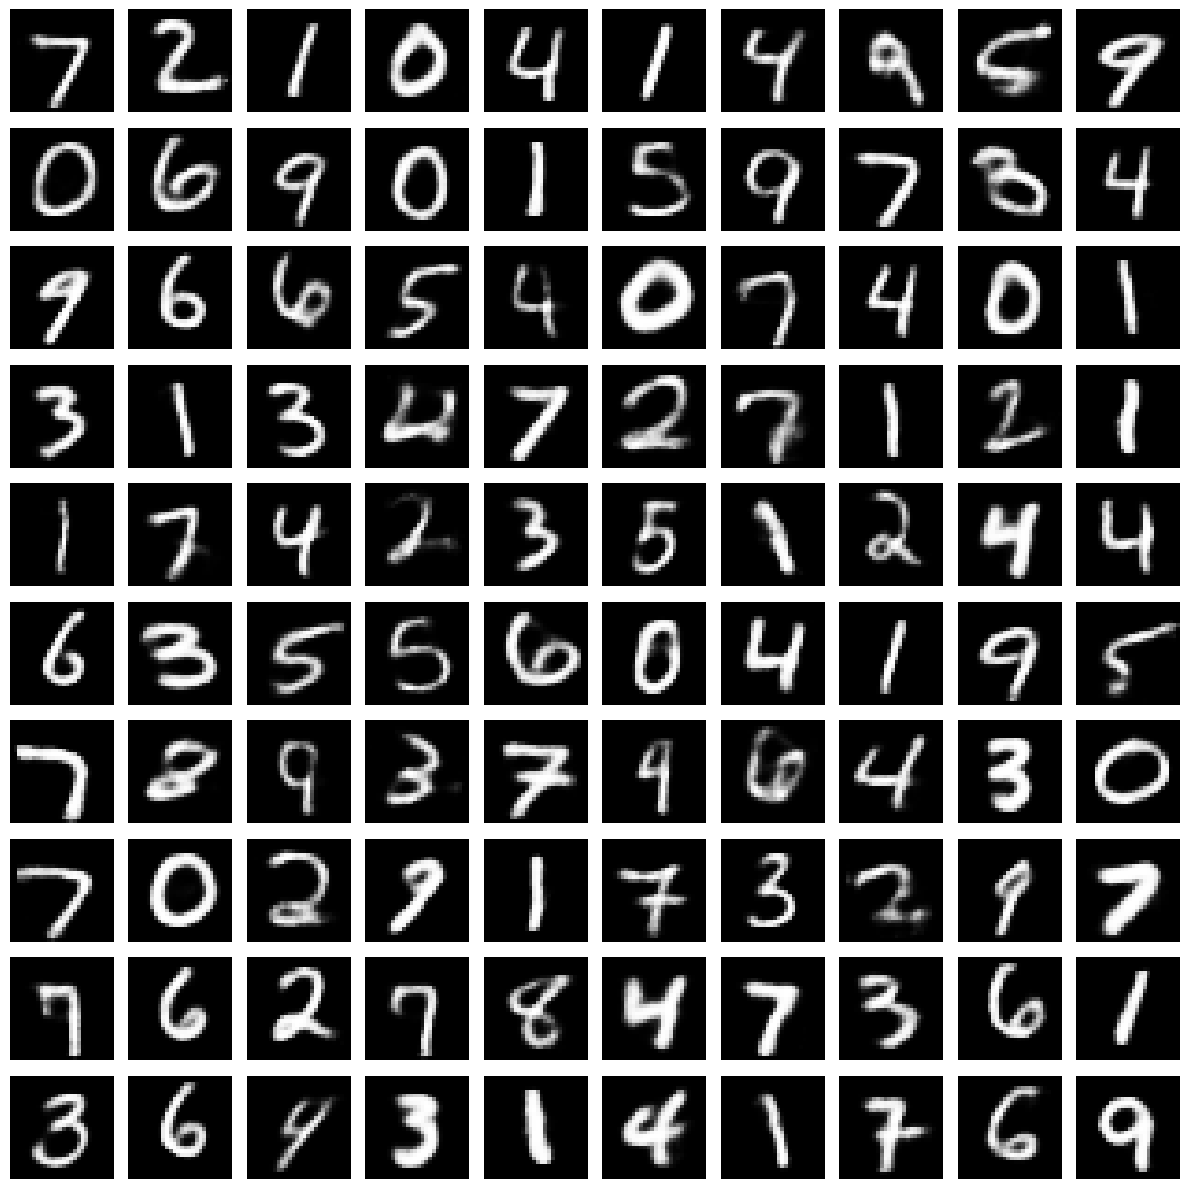

In [15]:
show_image_grid_detailed(x_hat)

### Step 6. Generate image from noise vector

If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

In [16]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

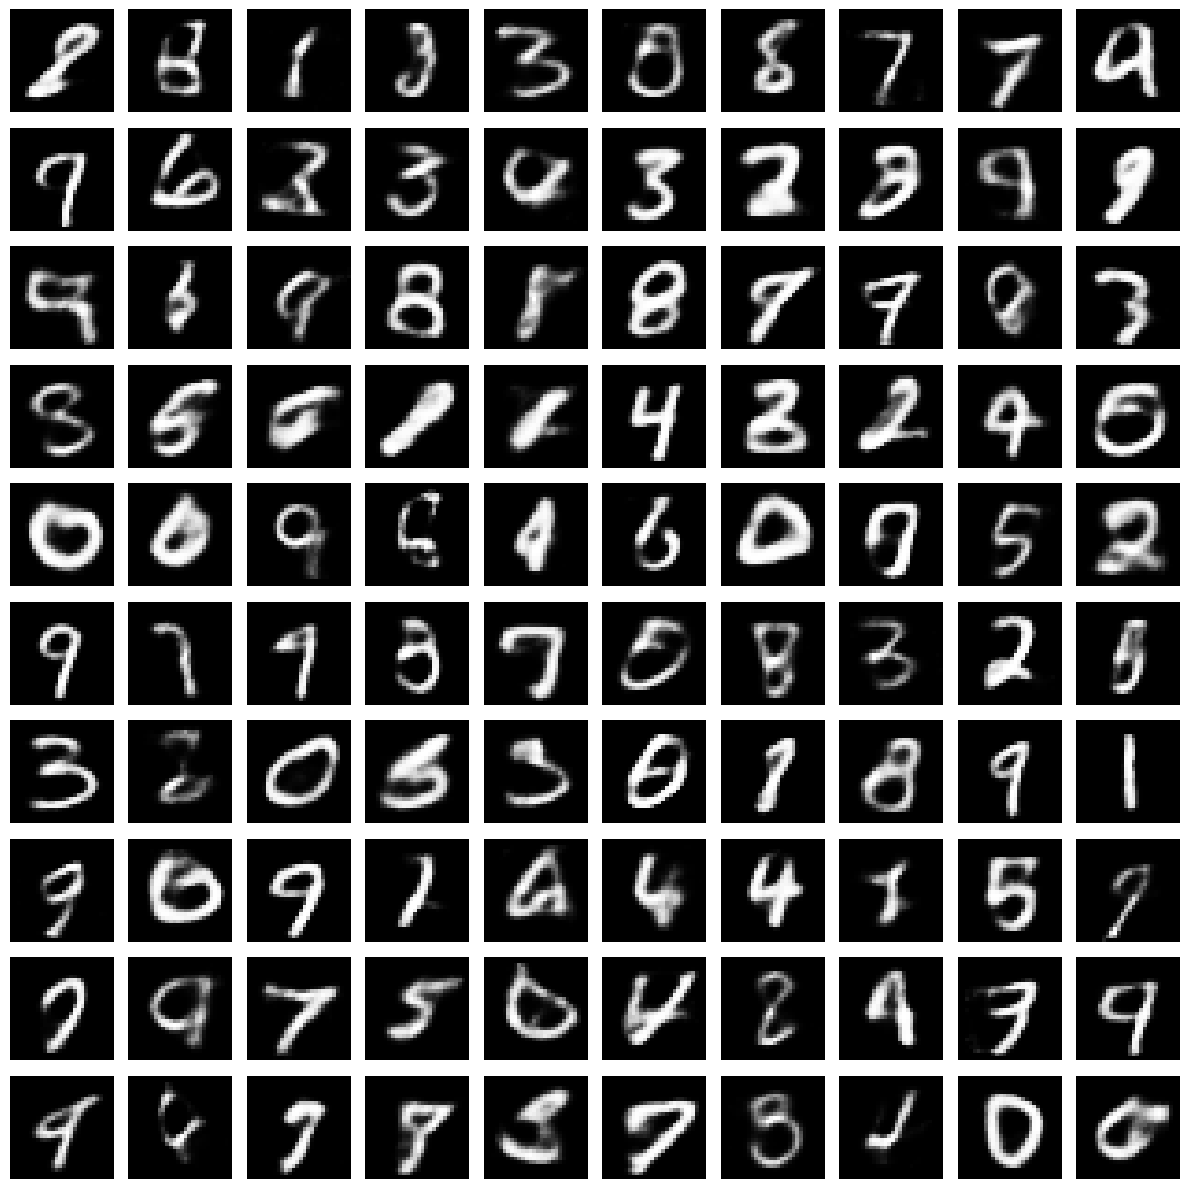

In [17]:
show_image_grid_detailed(generated_images)